In [5]:
from python_code.helper import plot_quadrotor
from python_code.simulator import quadrotor
from python_code.trajectory.differential_flatness_qc import trajectory_ref 
import numpy as np
from tqdm import tqdm
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
from python_code.data_driven.gen_func import GenerateWideArray
from python_code.data_driven.wynda import WyNDA
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [6]:
config = {
    "Ixx": 4.856e-3,
    "Iyy": 4.856e-3,
    "Izz": 8.801e-3,
    "b": 1.14e-8,
    "k": 2.980e-6,
    "l": 0.225,
    "m": 0.468,
    "g": 9.81,
}

def base_func(state, config):
  x, y, z = state[:3]
  phi, theta, psi = state[3:6]
  u, v, w = state[6:9]
  p, q, r = state[9:12]

  phi_dot = p
  theta_dot = q
  psi_dot = r

  p_dot = 0
  q_dot = 0
  r_dot = 0

  u_dot = config["g"]*theta
  v_dot = config["g"]*phi
  w_dot = 0

  x_dot = u
  y_dot = v
  z_dot = w

  return np.array([x_dot, y_dot, z_dot, phi_dot, theta_dot, psi_dot, u_dot, v_dot, w_dot, p_dot, q_dot, r_dot])

def basis_func(state, control):
  u1, u2, u3, u4 = control
  p, q, r = state[9:12]
  mu = np.array([1, u1, u2, u3, u4, p, q, r, p*q, p*r, q*r, p*q*r])
  return mu

In [7]:
def lemin_trajectory(t, a=2, tfac=1.2):
  x = (a * np.cos(np.sqrt(a) * t/ tfac))
  y = (a * np.sin(np.sqrt(a) * t / tfac) * np.cos(np.sqrt(a) * t / tfac))
  z = 0.0
  phi = 0.0
  return np.array([x, y, z, phi])

def circle_trajectory(t):
    """Circular trajectory in the x-y plane"""
    tfac = 1.2
    x = 2.0 * np.cos(np.sqrt(2) * t / tfac)
    y = 2.0 * np.sin(np.sqrt(2) * t / tfac)
    z = 0.0

    phi = 0.0
    return np.array([x, y, z, phi])

target = 5.5
dt = 0.01
t_ref = np.arange(0.0, target + dt, dt)

u_control, state_ref, traj_ref = trajectory_ref(t_ref=t_ref, config=config, trajectory=circle_trajectory)

qc = quadrotor.Quadrotor(config=config, initial_state=state_ref[0])
# plot_quad = plot_quadrotor.Plot_Quadrotor(init_state=state_ref[0], 
#                                           trajectory_ref=traj_ref, 
#                                           xlimit=[-3, 3],
#                                           ylimit=[-3, 3],
#                                           zlimit=[-3, 3],
#                                           show_animation=False) # For animation

wynda = WyNDA(n_state = 12, n_params=144, init_state=state_ref[0])
gen_func = GenerateWideArray(n_state=12)

state_history = np.zeros((len(t_ref), 12))
wynda_states = np.zeros((len(t_ref), 12))
control_history = np.zeros((len(t_ref), 4))

In [10]:
print("\n  " + Fore.WHITE + Back.GREEN + '\033[1m\t\tSTART SIMULATION\t\t\033[1m'+Style.RESET_ALL+"\n")

for i, t in tqdm(enumerate(t_ref), total=len(t_ref), colour="red"):
    state = qc.update_state(control=u_control[i], dt=dt)
    base = base_func(state=state, config=config)
    basis = basis_func(state=state, control=u_control[i])
    Phi = gen_func.custom(basis_function=basis)
    wynda_state, wynda_params = wynda.run(input=state, wide_array=Phi, dt=dt, base=base)
    # plot_quad.update_pose(state) # For animation
    state_history[i, :] = state
    wynda_states[i, :] = wynda_state
    control_history[i, :] = u_control[i]


  		START SIMULATION		



100%|██████████| 551/551 [00:04<00:00, 132.50it/s]


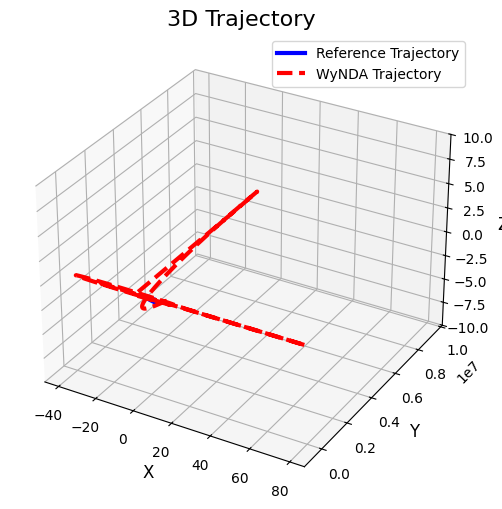

In [11]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(state_history[:, 0], state_history[:, 1], state_history[:, 2], "b", label="Reference Trajectory", linewidth=3)
ax.plot(wynda_states[:, 0], wynda_states[:, 1], wynda_states[:, 2], "r--", label="WyNDA Trajectory", linewidth=3)

ax.set_title('3D Trajectory', fontsize=16)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)

ax.set_zlim(-10, 10)

ax.legend()

plt.show()


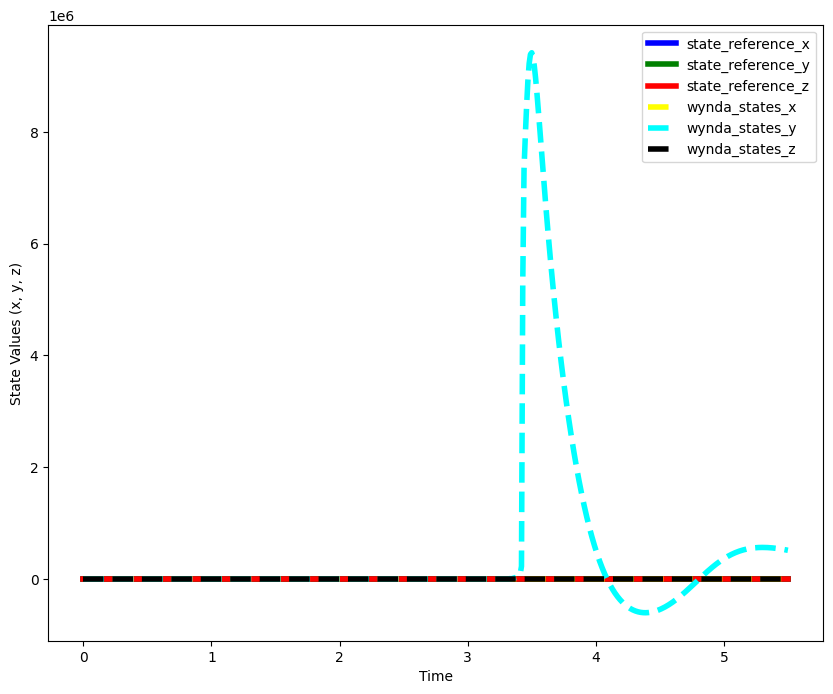

In [12]:
plt.figure(figsize=(10,8))

plt.plot(t_ref, state_history[:, 0], "b", label="state_reference_x", linewidth=4)
plt.plot(t_ref, state_history[:, 1], "g", label="state_reference_y", linewidth=4)
plt.plot(t_ref, state_history[:, 2], "r", label="state_reference_z", linewidth=4)

plt.plot(t_ref, wynda_states[:, 0], "--", color="yellow", label="wynda_states_x", linewidth=4)
plt.plot(t_ref, wynda_states[:, 1], "--", color="cyan",label="wynda_states_y", linewidth=4)
plt.plot(t_ref, wynda_states[:, 2], "--", color="black", label="wynda_states_z", linewidth=4)

plt.xlabel('Time')
plt.ylabel('State Values (x, y, z)')
plt.legend()
plt.show()

In [23]:
dt_params = wynda_params/dt
df_params = pd.DataFrame(np.round(dt_params, 3).reshape(12, 12))

In [24]:
df_params

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.007,0.019,-0.008,-0.017,0.002,-0.142,0.120,-0.000,0.006,-0.088,-0.002
1,0.0,0.080,-0.038,-0.024,-0.018,0.128,0.012,0.039,0.010,0.089,0.012,-0.005
2,0.0,-0.025,0.019,-0.001,0.010,0.073,-0.014,0.165,-0.006,0.037,-0.008,-0.002
3,0.0,-0.000,-0.001,-0.000,0.002,-0.000,-0.001,0.000,-0.000,-0.000,-0.000,0.000
4,0.0,-0.002,0.011,0.001,-0.011,0.001,-0.012,0.011,-0.000,0.000,-0.011,-0.000
5,0.0,-0.008,-0.008,-0.004,0.022,-0.021,0.036,-0.566,-0.009,-0.013,0.024,0.003
6,0.0,0.175,-0.050,-0.050,-0.073,0.358,0.053,0.064,0.021,0.239,0.031,-0.013
7,-0.0,0.019,-3.834,0.060,3.752,-0.118,-2.811,0.272,0.017,-0.073,-0.330,-0.008
8,-0.0,0.025,-0.001,0.006,-0.030,0.031,0.027,0.136,0.010,0.021,0.011,0.000
9,0.0,0.003,-0.273,0.003,0.267,-0.006,-0.170,0.014,0.002,-0.003,-0.006,-0.000


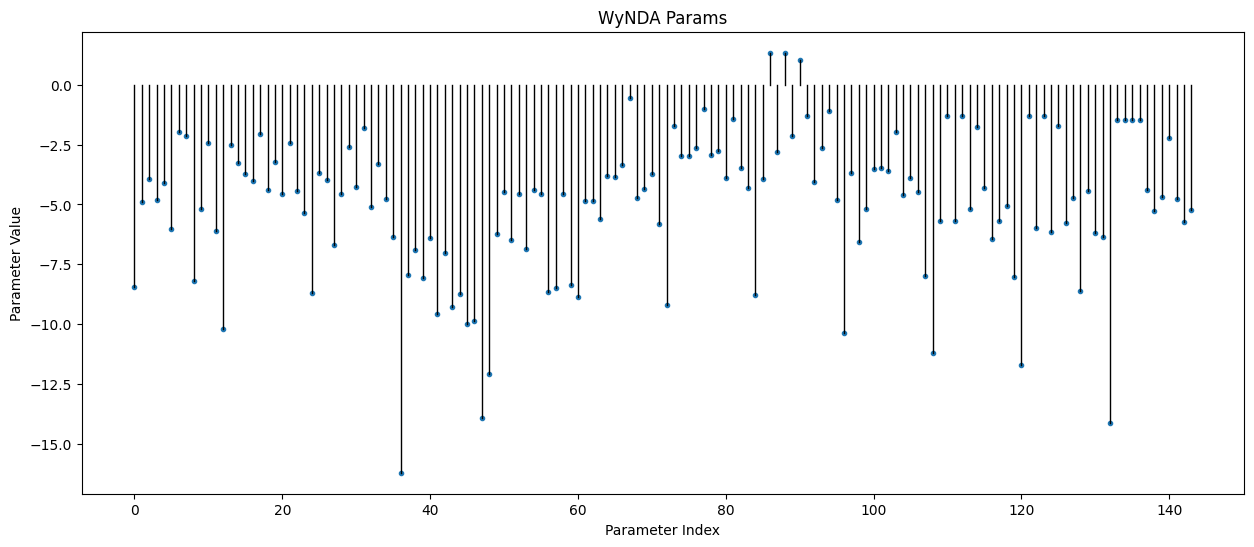

In [26]:
log_map = np.log(np.abs(dt_params))

plt.figure(figsize=(15, 6))
plt.plot(log_map, 'o', markersize=3)

for i, value in enumerate(log_map):
  plt.plot([i, i], [0, value], 'k-', linewidth=1)

plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.title('WyNDA Params')

# Show the plot
plt.show()


In [29]:
dt_params[np.where(np.log(np.abs(dt_params)) > 0.0)]

array([-3.83446104,  3.75178458, -2.81109772])